# Wind Profile in Illinois

This notebook calculates an average hourly capacity factor for wind turbines in Illinois.

We use a reference wind farm, Railsplitter Wind Farm, located in Lincoln, IL. The data was provided
by the University of Illinois F\&S Department. UIUC has a power purchase agreement with Railsplitter Wind Farm.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(12,9)
plt.rcParams['font.size']=16
plt.style.use('ggplot')

colors = {'spring':'tab:green',
          'summer':'tab:red',
          'fall':'tab:orange',
          'winter':'tab:blue'}

In [2]:
railsplitter_df = pd.read_csv("../railsplitter_data.csv", parse_dates=True, index_col='time')
railsplitter_df = pd.read_csv("../TypicalRailSplitter_0.csv", parse_dates=True, index_col='time')
# railsplitter_df = pd.read_csv("../railsplitterHistories/RailSplitterHistories_4_pd.csv", parse_dates=True, index_col='time')
railsplitter_df.rename(columns={'mw':'kw'}, inplace=True)
# railsplitter_df.mw = railsplitter_df.mw*1000
railsplitter_df

,kw
time,
0,0.800
1,0.200
2,0.200
3,0.100
4,0.000
...,...
8755,6.106
8756,5.504
8757,6.450


In [3]:
yearhours = pd.date_range(start='2019', end='2020', freq='H')[:8760]
# yearhours
railsplitter_df['year'] = yearhours
railsplitter_df = railsplitter_df.set_index('year')#.drop(columns=['time'])
railsplitter_df

,kw
year,
2019-01-01 00:00:00,0.800
2019-01-01 01:00:00,0.200
2019-01-01 02:00:00,0.200
2019-01-01 03:00:00,0.100
2019-01-01 04:00:00,0.000
...,...
2019-12-31 19:00:00,6.106
2019-12-31 20:00:00,5.504
2019-12-31 21:00:00,6.450


In [4]:
year = 0
railsplitter_df = railsplitter_df[8760*year:8760*(year+1)]
railsplitter_df

,kw
year,
2019-01-01 00:00:00,0.800
2019-01-01 01:00:00,0.200
2019-01-01 02:00:00,0.200
2019-01-01 03:00:00,0.100
2019-01-01 04:00:00,0.000
...,...
2019-12-31 19:00:00,6.106
2019-12-31 20:00:00,5.504
2019-12-31 21:00:00,6.450


In [5]:
hours_grouped = railsplitter_df.groupby(railsplitter_df.index.hour)

In [6]:
avg_hourly = np.zeros(len(hours_grouped))
std_hourly = np.zeros(len(hours_grouped))
for i, hour in enumerate(hours_grouped.groups):
    hour_data = hours_grouped.get_group(hour)
    avg_hourly[i] = hour_data.kw.mean()
    std_hourly[i] = hour_data.kw.std()

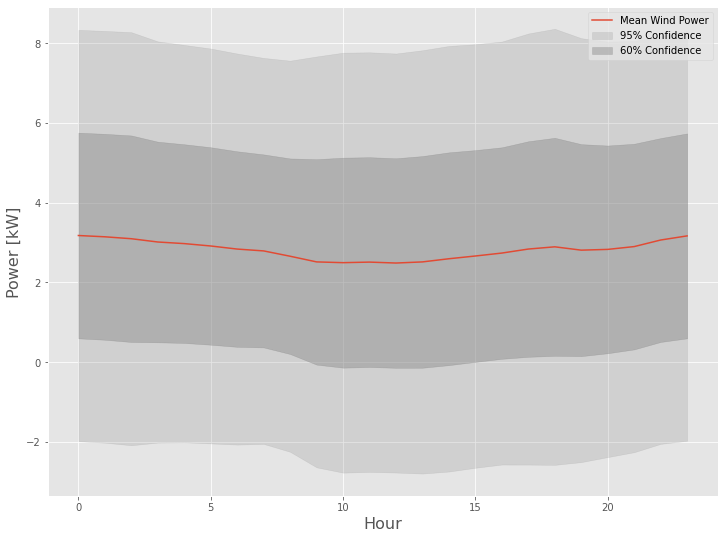

In [7]:
plt.figure(figsize=(12,9))
plt.plot(range(24), avg_hourly, label='Mean Wind Power')
plt.fill_between(range(24),
                 avg_hourly + 2 * std_hourly,
                 avg_hourly - 2 * std_hourly,
                 color='gray', alpha=0.2, label='95% Confidence')
plt.fill_between(range(24),
                 avg_hourly + std_hourly,
                 avg_hourly - std_hourly,
                 color='gray', alpha=0.4
                 , label='60% Confidence')
plt.legend()
plt.xlabel('Hour',fontsize=16)
plt.ylabel('Power [kW]',fontsize=16)
# plt.savefig("../report/img/cap/wind_mean.png")
plt.show()

As expected, the uncertainty is huge. Wind can take on any value at any time and is difficult to predict. So let's just use the average value to generate our "profile."

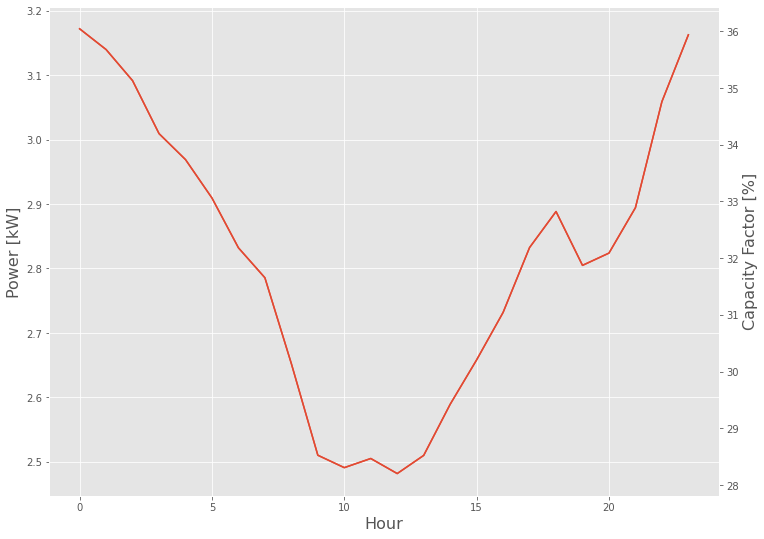

In [8]:
fig, ax = plt.subplots()
fig.figsize=(12,9)
ax.plot(range(24), avg_hourly, label='Mean Wind Power')
ax2 = ax.twinx()
ax2.plot(range(24), avg_hourly/railsplitter_df.kw.max()*100)
ax.set_xlabel('Hour',fontsize=16)
ax.set_ylabel('Power [kW]',fontsize=16)
ax2.set_ylabel('Capacity Factor [%]',fontsize=16)
plt.grid(which='major')
plt.show()
# fig.savefig("../report/img/cap/wind_cf.png")

In [9]:
avg_hourly.mean()/railsplitter_df.kw.max()

0.31961410336239116

In [10]:
for i, v in enumerate(avg_hourly):
    print(f"Hour {i+1} : {v/railsplitter_df.kw.max()} CF")

Hour 1 : 0.36045392278953914 CF
Hour 2 : 0.3567932752179328 CF
Hour 3 : 0.3513088418430888 CF
Hour 4 : 0.3419651307596516 CF
Hour 5 : 0.33738605230386054 CF
Hour 6 : 0.33060709838107094 CF
Hour 7 : 0.3218256537982568 CF
Hour 8 : 0.3165429638854296 CF
Hour 9 : 0.3013854296388544 CF
Hour 10 : 0.28523723536737267 CF
Hour 11 : 0.2830485678704859 CF
Hour 12 : 0.2846612702366129 CF
Hour 13 : 0.28200498132004986 CF
Hour 14 : 0.2852092154420921 CF
Hour 15 : 0.294222291407223 CF
Hour 16 : 0.30205853051058545 CF
Hour 17 : 0.31042652552926525 CF
Hour 18 : 0.32186986301369874 CF
Hour 19 : 0.3282241594022416 CF
Hour 20 : 0.31872789539227914 CF
Hour 21 : 0.3208904109589043 CF
Hour 22 : 0.32889850560398504 CF
Hour 23 : 0.3476021170610213 CF
Hour 24 : 0.3593885429638861 CF


## Seasonal Differences in Average Capacity Factor 

In [11]:
railsplitter_df

,kw
year,
2019-01-01 00:00:00,0.800
2019-01-01 01:00:00,0.200
2019-01-01 02:00:00,0.200
2019-01-01 03:00:00,0.100
2019-01-01 04:00:00,0.000
...,...
2019-12-31 19:00:00,6.106
2019-12-31 20:00:00,5.504
2019-12-31 21:00:00,6.450


In [12]:
spring_mask = (railsplitter_df.index.month >= 3) & (railsplitter_df.index.month <= 5) 
summer_mask = (railsplitter_df.index.month >= 6) & (railsplitter_df.index.month <= 8)
fall_mask = (railsplitter_df.index.month >= 9) & (railsplitter_df.index.month <= 11) 
winter_mask = (railsplitter_df.index.month == 12) | (railsplitter_df.index.month == 1) | (railsplitter_df.index.month == 2) 
seasons = {'spring':spring_mask,
           'summer':summer_mask,
           'fall':fall_mask,
           'winter':winter_mask}
seasonal_hourly_profile = {}

In [13]:
for season in seasons:
    mask = seasons[season]
    df = railsplitter_df[mask]
    hours_grouped = df.groupby(df.index.hour)
    
    avg_hourly = np.zeros(len(hours_grouped))
    std_hourly = np.zeros(len(hours_grouped))
    for i, hour in enumerate(hours_grouped.groups):
        hour_data = hours_grouped.get_group(hour)
        avg_hourly[i] = hour_data.kw.mean()
        std_hourly[i] = hour_data.kw.std()
        
    seasonal_hourly_profile[season] = avg_hourly
    colname = season+"_cf"
    seasonal_hourly_profile[colname] = avg_hourly/railsplitter_df.kw.max()

In [14]:
seasonal_df = pd.DataFrame(seasonal_hourly_profile)
seasonal_df

,spring,spring_cf,summer,summer_cf,fall,fall_cf,winter,winter_cf
0,3.419565,0.388587,2.303261,0.261734,3.340242,0.379573,3.636844,0.413278
1,3.534783,0.401680,2.303261,0.261734,3.209209,0.364683,3.520911,0.400104
2,3.640217,0.413661,2.108696,0.239625,3.128835,0.355549,3.497556,0.397449
3,3.440217,0.390934,2.123913,0.241354,3.057165,0.347405,3.425444,0.389255
4,3.395652,0.385870,2.029348,0.230608,3.086330,0.350719,3.374756,0.383495
5,3.454348,0.392540,2.047826,0.232708,2.894286,0.328896,3.248111,0.369104
6,3.427174,0.389452,1.997826,0.227026,2.732440,0.310504,3.177244,0.361051
7,3.533696,0.401556,1.936957,0.220109,2.536330,0.288219,3.140333,0.356856
8,3.380435,0.384140,1.581522,0.179718,2.416484,0.274600,3.240556,0.368245
9,3.244565,0.368701,1.302174,0.147974,2.171934,0.246811,3.335956,0.379086


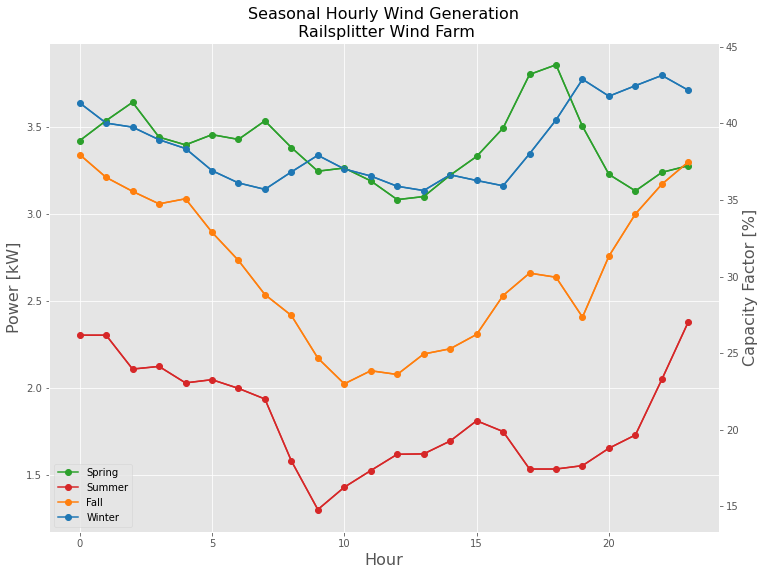

In [15]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
fig.figsize=(12,9)
for season in seasons:
    cf_key = season+"_cf"
    ax.plot(range(24), seasonal_df[season], label=season.capitalize(), color=colors[season], marker='o')
    ax2.plot(range(24), seasonal_df[cf_key]*100, color=colors[season])
ax.set_xlabel('Hour',fontsize=16)
ax.legend()
ax.set_ylabel('Power [kW]',fontsize=16)
ax2.set_ylabel('Capacity Factor [%]',fontsize=16)
ax.set_title('Seasonal Hourly Wind Generation\n Railsplitter Wind Farm',fontsize=16)
# fig.savefig("../report/img/cap/seasonal_hourly_wind.png")
plt.grid(which='major')

plt.show()

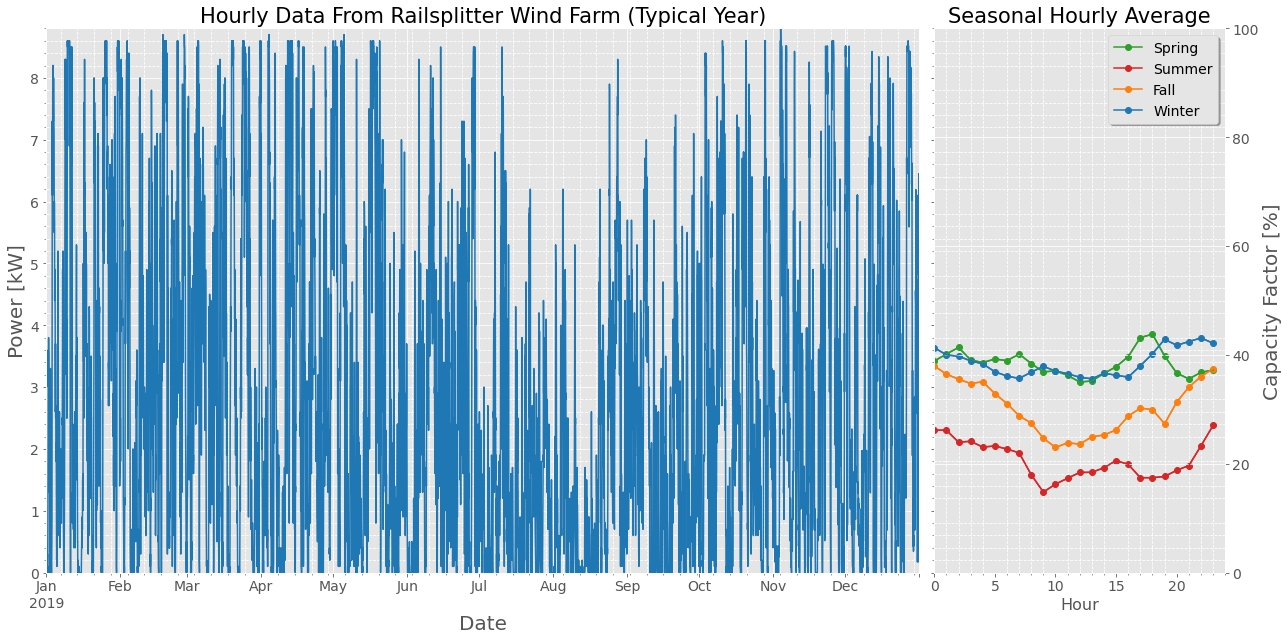

In [17]:
fig, axes = plt.subplots(1,2,figsize=(18,9),gridspec_kw={'width_ratios': [3, 1]}, sharey=True)
ax2 = axes[1].twinx()
# fig.figsize=(12,9)
for season in seasons:
    cf_key = season+"_cf"
    axes[1].plot(range(24), seasonal_df[season], label=season.capitalize(), color=colors[season], marker='o')
    ax2.plot(range(24), seasonal_df[cf_key]*100, color=colors[season])
axes[1].set_xlabel('Hour',fontsize=16)
axes[1].set_title("Seasonal Hourly Average", fontsize=21)
axes[0].set_title("Hourly Data From Railsplitter Wind Farm (Typical Year)", fontsize=21)
axes[1].legend(fontsize=14, fancybox=True, shadow=True)
axes[0].set_ylabel('Power [kW]',fontsize=20)
ax2.set_ylabel('Capacity Factor [%]',fontsize=20)
axes[1].grid(which='major')
railsplitter_df.kw.plot(ax=axes[0], color='tab:blue', alpha=1)
axes[0].set_xlabel('Date', fontsize=20)
peak = max(railsplitter_df.kw)
axes[0].set_ylim(0,peak)
ax2.set_ylim(0,100)
ax2.set_xlim(0,24)
axes[1].set_ylim(0,peak)
axes[1].set_xlim(0,24)
axes[1].minorticks_on()
# axes[0].minorticks_on()
axes[1].grid(which='minor', linestyle='--')
axes[0].grid(which='minor', linestyle='--')
ax2.grid(which='major', linestyle='-', color='w')
axes[0].tick_params(axis='both',labelsize=14)
axes[1].tick_params(axis='both',labelsize=14)
ax2.tick_params(axis='both',labelsize=14)
plt.tight_layout()
# plt.savefig('../../thesis/figures/solar_timeslice.pgf')
plt.show()